In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import calendar

In [2]:
pnc_path = r"C:\Users\willd\OneDrive\Desktop\Budget\statements\pnc_csvs"
chase_path = r"C:\Users\willd\OneDrive\Desktop\Budget\statements\chase_csvs"

In [3]:
# combine multiple pnc statements
def combine(path):
    df_list = []
    for item in os.listdir(path):
        full_path = os.path.join(path, item)
        df = pd.read_csv(full_path)
        df_list.append(df)
    combined = pd.concat(df_list)
    combined.columns.values[0] = "Date"
    no_dup = combined.drop_duplicates(subset=['Date', 'Description'], keep='first', inplace=False, ignore_index=True)
    return no_dup

# function to fill ammount column in the pnc dataframe 
def amount_fill(data):
    if '$' in str(data['Withdrawals']):
        amount = '-' + data['Withdrawals']
    else:
        amount = data['Deposits']
    return float(amount.replace('$', '').replace(',', ''))

In [4]:
#compile all files in each folder
pnc_full = combine(pnc_path)
chase_full = combine(chase_path)

#make one row of just amount from withdrawls and eposits
pnc_full['Amount'] = pnc_full.apply(amount_fill, axis=1)

# add catacories to pnc data frame 
df = pnc_full['Description']
df2 = pnc_full['Amount']
cat_condition = [(df.str.contains('VENMO')) & (df2 > 0) & (df2 < 600),(df.str.contains('VENMO'))& (df2 > 0) & (df2 > 600), (df.str.contains('VENMO')) & (df2 < 0), (df.str.contains('SPOTIFY') | df.str.contains('APPLE')),
                 (df.str.contains('ACTALENT')), (df.str.contains('CHECK'))
                , (df.str.contains('SCHWAB BROK'))]
cat_value = ['VENMO IN','KIKI RENT','VENMO OUT', 'SUBSCRIP', 'Belair', 'RENT', 'SCHWAB']
pnc_full['Category'] = np.select(cat_condition, cat_value)
# make a misc catagory of remaining  
pnc_full.loc[pnc_full['Category'] == '0', 'Category'] = 'Misc'

In [70]:
# reduce both data frames to relevant columns
chase_reduced = chase_full[["Date", 'Description', "Category", "Amount"]]
pnc_reduced = pnc_full[["Date", 'Description', "Category", "Amount"]]

# remove CC Payments from both 
pnc_no_cc = pnc_reduced[~pnc_reduced['Description'].str.contains('CHASE CREDIT CRD EPA')]
# remove pnc transfers 
pnc_no_transfer = pnc_no_cc[~pnc_no_cc['Description'].str.contains('ONLINE TRANSFER')]
chase_no_cc = chase_reduced[chase_reduced['Amount'] < 0]

# combine pnc and chase for analysis 
both = [chase_no_cc, pnc_no_transfer]
full_df = pd.concat(both)

# change date dtype
full_df['Date'] = pd.to_datetime(full_df['Date'])

#reduce data set to only include same months 
full_df = full_df[full_df['Date'] >= '2023-09-01']

# add month column 
full_df['Month'] = pd.DatetimeIndex(full_df['Date']).month
# change month colum to date
full_df['Month'] = full_df['Month'].apply(lambda x: calendar.month_abbr[x])
full_df = full_df.sort_values(by='Date')

In [71]:
month_list = full_df['Month'].unique()
for mon1 in month_list:
    month_df = full_df[full_df['Month'] == mon1]
    k_rent = month_df.loc[month_df['Category'] == 'KIKI RENT', 'Amount']
    w_rent = month_df.loc[month_df['Category'] == 'RENT', 'Amount']  
    if (len(k_rent) > 0) & (len(w_rent) > 0):
        w_index = w_rent.index
        w_index = w_index[0]
        rent_actual = w_rent.iloc[0] + k_rent.iloc[0]
        full_df.loc[(full_df['Category'] == 'RENT')&(full_df['Month'] == mon1), 'Amount'] = rent_actual

-710.0
-1000.0


In [79]:
full_df = full_df[full_df['Category'] != 'KIKI RENT']

In [80]:
full_df[full_df['Category'] == 'KIKI RENT']

,Date,Description,Category,Amount,Month


In [81]:
full_df[full_df['Category'] == 'RENT']

,Date,Description,Category,Amount,Month
42,2023-10-02,CHECK 148 010880600,RENT,-710.0,Oct
18,2023-11-03,CHECK 150 009542228,RENT,-1000.0,Nov


In [82]:
money_in = full_df[full_df['Amount'] > 0]
money_out = full_df[full_df['Amount'] < 0]

In [83]:
money_out.loc[money_out['Amount'] < 0, 'Amount'] = 0 - money_out['Amount']

C:\Users\willd\AppData\Local\Temp\ipykernel_9220\1903825643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_out.loc[money_out['Amount'] < 0, 'Amount'] = 0 - money_out['Amount']


In [13]:
# money_out['Amount'] = 0 - money_out['Amount']

In [54]:
money_out.head(5)

,Date,Description,Category,Amount,Month
0,2023-12-02,TST* WINDY SADDLE CAFE,Food & Drink,54.29,Dec
1,2023-12-01,PARKMOBILE,Travel,2.45,Dec
2,2023-11-29,PROGRESSIVE INS,Bills & Utilities,594.00,Nov
3,2023-11-27,KING SOOPERS #0682 FUE,Gas,47.75,Nov
5,2023-11-26,ZENNI OPTICAL INC.,Health & Wellness,4.95,Nov


In [84]:
month_list = full_df['Month'].unique()
dict_list = []
for mon in month_list:
    df_in = money_in[money_in['Month'] == mon]
    df_out = money_out[money_out['Month'] == mon]
    month_in = df_in['Amount'].sum()
    month_out = df_out['Amount'].sum()
    dict1 = {'Month': mon, 'Money In': month_in, 'Money Out': month_out}
    dict_list.append(dict1)
monthly_ratio = pd.DataFrame(dict_list)

In [56]:
monthly_ratio

,Month,Money In,Money Out
0,Dec,0.00,56.74
1,Nov,6634.92,3512.73
2,Oct,5650.98,6299.18
3,Sep,5699.02,3360.89


In [131]:


# Visualization functions
# Pie Chart
def monthly_pie(cat_tot, month):
    total_out = round(cat_tot['Amount'].sum(), 2)
    labels = cat_tot.index.tolist()
    sizes = cat_tot['Amount']
    pie = plt.pie(sizes,autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title(f"{month} Expenses by Category ${total_out}")
    labels = [f'{l}, {round(s/total_out*100),2}%' for l, s in zip(labels, sizes)]
    plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels)
#     plt.close()

#bar chart
def bar_chart(cat_tot, month):
    total_out = round(cat_tot['Amount'].sum(), 2)
    x = cat_tot.index.tolist()
    y = cat_tot['Amount']
    fig, ax = plt.subplots()
    # Horizontal Bar Plot
    ax.barh(x, y)
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    # Show top values 
    ax.invert_yaxis()
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5, 
                 str(round((i.get_width()), 2)),
                 fontsize = 10, fontweight ='bold',
                 color ='grey')
    # Add Plot Title
    ax.set_title(f"{month} Expenses by Category ${total_out} ",
                 loc ='left', )

    # Add Text watermark
    fig.text(0.9, 0.15, 'wcd', fontsize = 12,
             color ='grey', ha ='right', va ='bottom',
             alpha = 0.7)
#     plt.close()

# Montly Expense to Income
def all_months_bar(monthly_ratio):
    total_inc = round(monthly_ratio['Money In'].sum(), 2)
    total_exp = round(monthly_ratio['Money Out'].sum(), 2)
    ax = monthly_ratio.plot(
        x='Month', y = 'Money In', linestyle='-', color="r", marker='o',use_index=False)
    monthly_ratio.plot(x='Month', y = 'Money Out', kind='bar',
                                                            ax=ax)
    plt.title("Montly Expense to Income")
    plt.xticks(rotation=45, ha='right')
    plt.figtext(0.5, -.1, f"Total Income: {total_inc} Total Expenses: {total_exp}", 
                ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.show()

In [121]:
monthly_ratio

,Month,Money In,Money Out
0,Sep,4789.91,3360.89
1,Oct,4800.98,5449.18
2,Nov,5954.92,2832.73
3,Dec,0.00,56.74


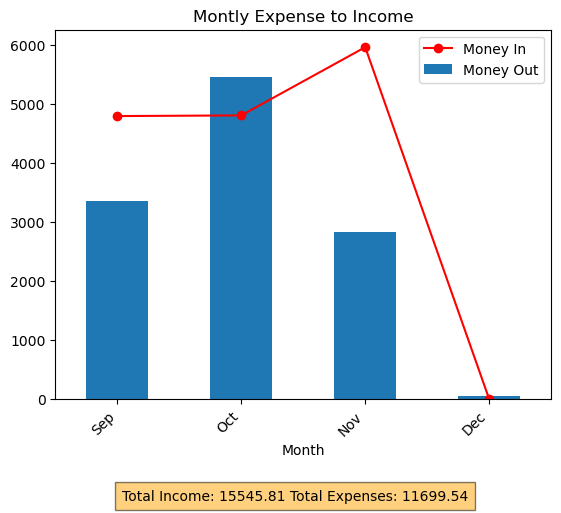

In [130]:
all_months_bar(monthly_ratio)

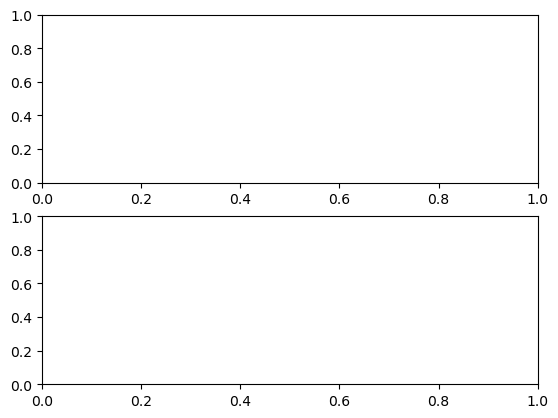

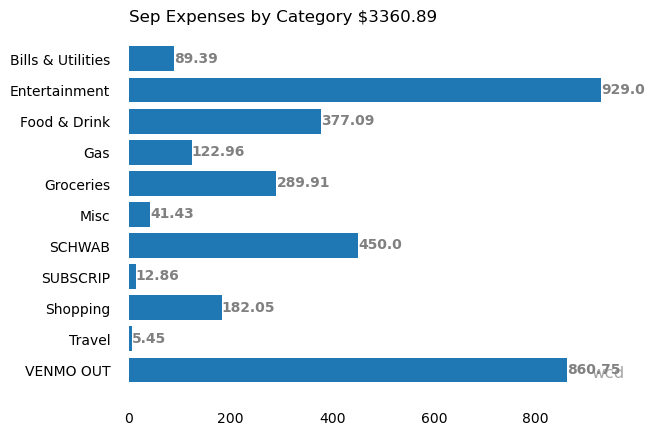

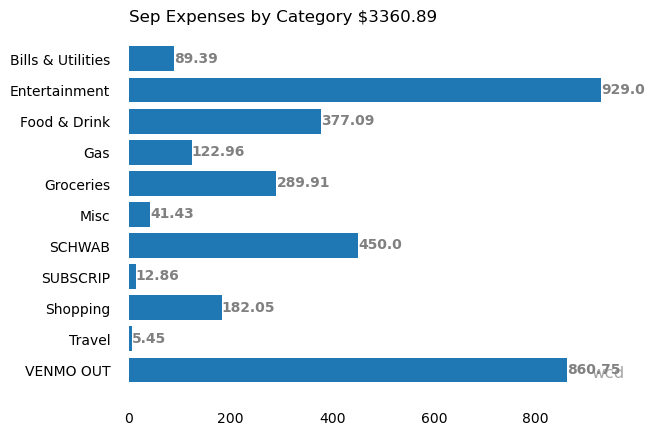

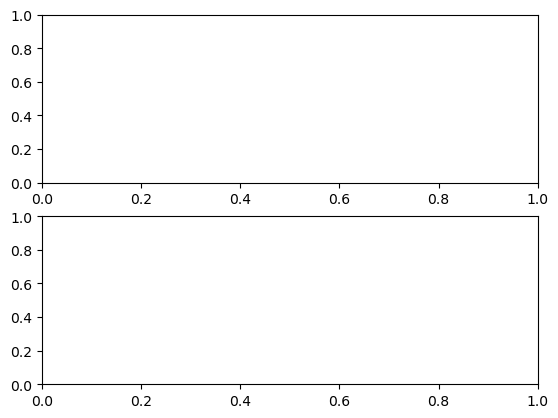

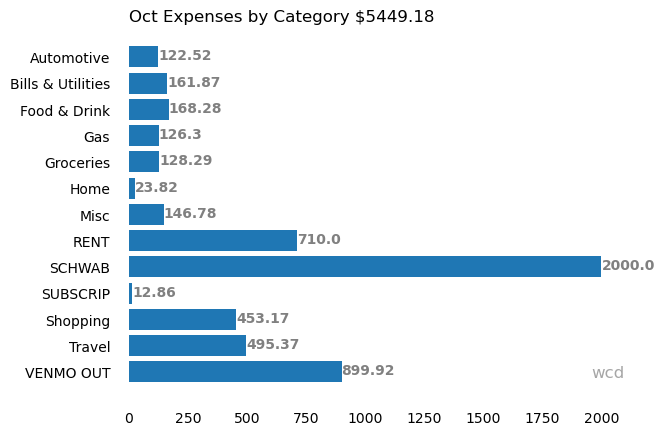

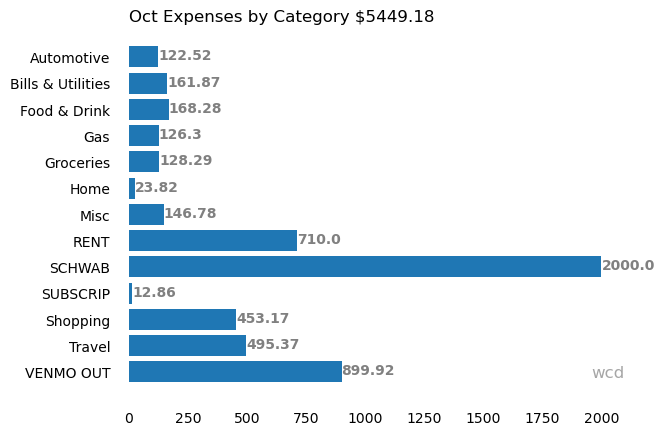

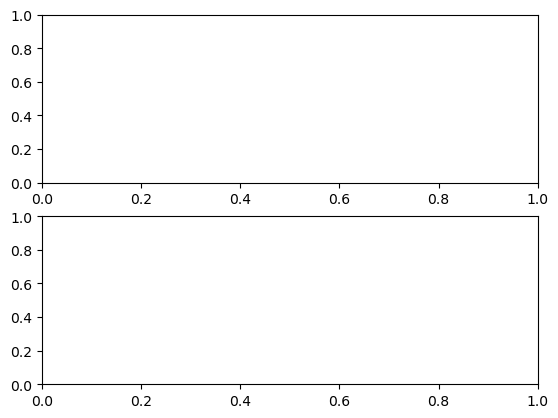

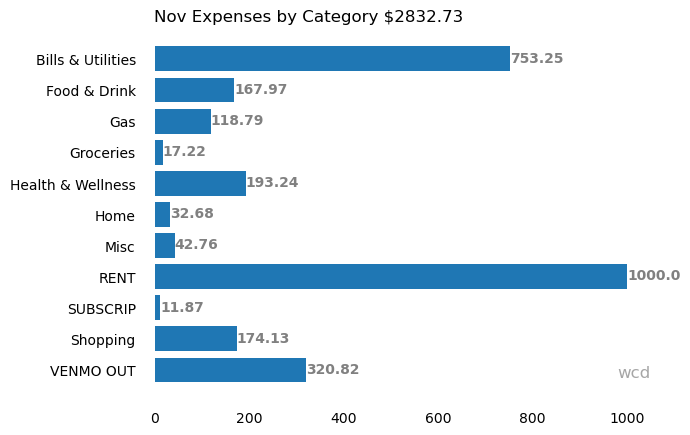

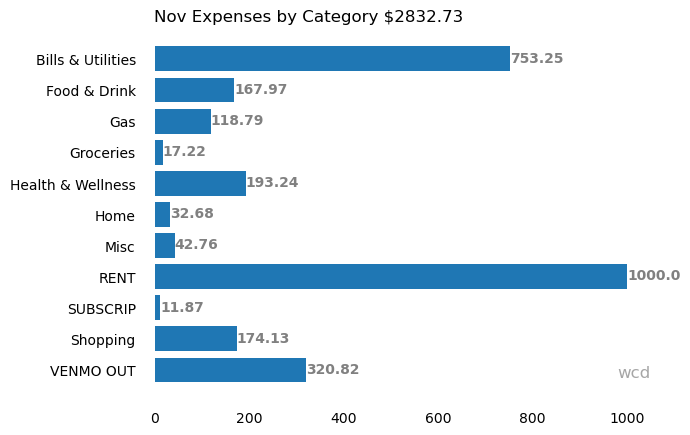

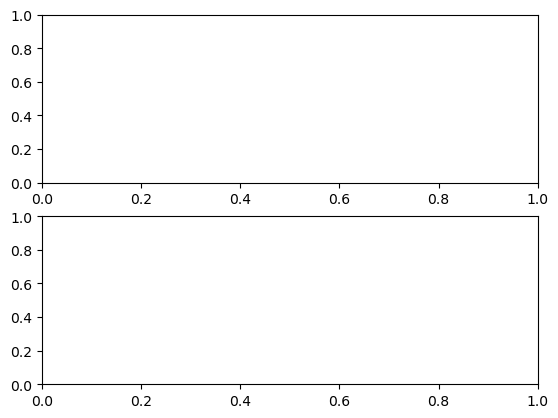

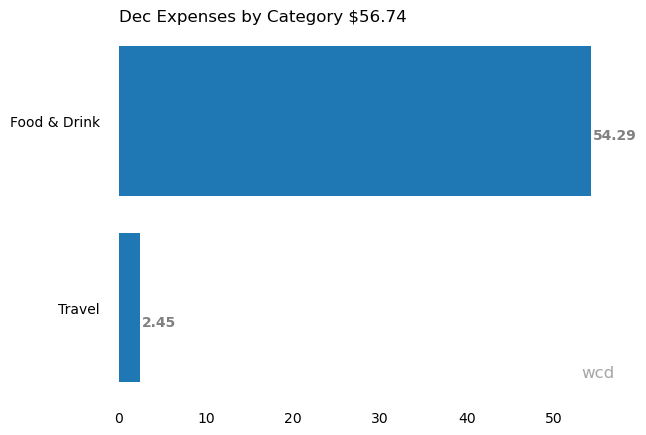

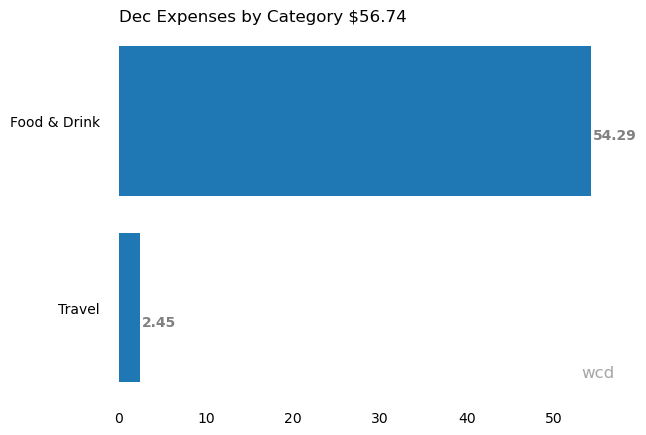

In [143]:
month_list = full_df['Month'].unique()
for mon in month_list:
    month_df = money_out[money_out['Month'] == mon]
#     month_df = money_in[money_in['Month'] == mon]
    cat_tot = month_df.groupby('Category').sum()
    
    fig, axs = plt.subplots(2)
#     fig.suptitle('Vertically stacked subplots')
#     axs[1] = monthly_pie(cat_tot, str(mon))
    axs[0] = bar_chart(cat_tot, mon)
    axs[1] = bar_chart(cat_tot, mon)
#     monthly_pie(cat_tot, mon)
#     bar_chart(cat_tot, mon)

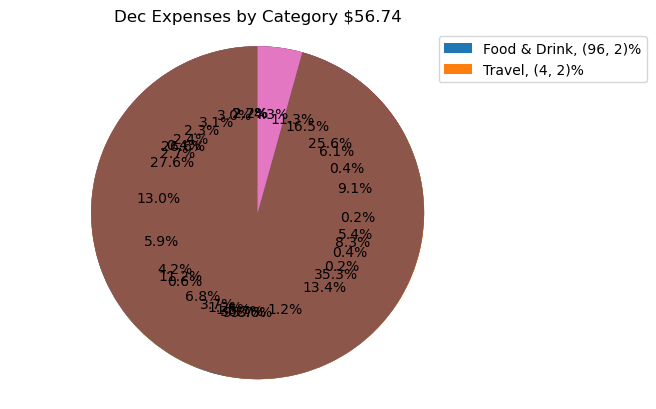

In [139]:
month_list = full_df['Month'].unique()
for mon in month_list:
    month_df = money_out[money_out['Month'] == mon]
#     month_df = money_in[money_in['Month'] == mon]
    cat_tot = month_df.groupby('Category').sum()
    
    monthly_pie(cat_tot, mon)
#     bar_chart(cat_tot, mon)

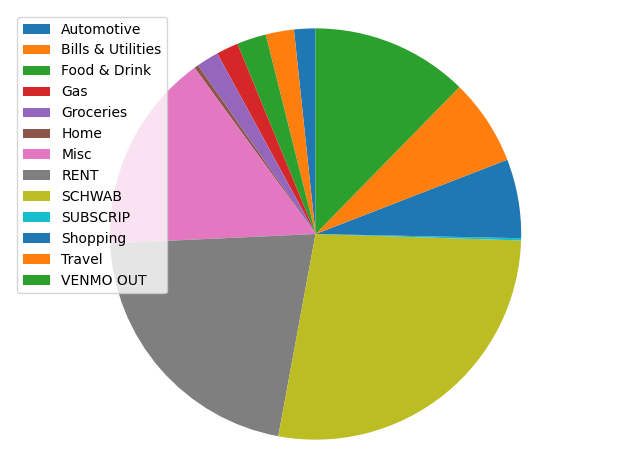

In [32]:
labels = cat_tot.index.tolist()
amounts = cat_tot['Amount']

patches, texts = plt.pie(amounts, startangle=90)
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.show()